In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 7, 21, 22, 2, 808854)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-07 21:22:02,841 INFO: Initializing external client
2025-01-07 21:22:02,842 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 21:22:04,653 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION_1 = "MOUNTJOY SQUARE WEST"
STATION_2 = "HEUSTON BRIDGE (NORTH)"

STATION_1 = STATION_1.replace(" ", "_")
STATION_2 = STATION_2.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model_1 = mr.get_model(
    name="bike_availability_xgboost_model_1",
    version=1,
)

retrieved_model_2 = mr.get_model(
    name="bike_availability_xgboost_model_2",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model_1.download()
saved_model_dir = retrieved_model_2.download()

In [8]:
retrieved_xgboost_model_1 = XGBRegressor()

retrieved_xgboost_model_1.load_model(saved_model_dir + "/model_1.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model_1

In [9]:
retrieved_xgboost_model_2 = XGBRegressor()

retrieved_xgboost_model_2.load_model(saved_model_dir + "/model_2.json")

# Displaying the retrieved XGBoost regressor model
#retrieved_xgboost_model_2

In [10]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-16 22:00:00+00:00,5.05,2.094080,0.0,0.0,10.948973,29183.220703,0.0,dublin,1,3,22
1,2025-01-14 08:00:00+00:00,10.45,9.437586,0.0,0.0,6.439876,28859.789062,0.0,dublin,1,1,8
2,2025-01-15 15:00:00+00:00,6.70,5.603458,0.0,0.0,1.297998,29019.097656,0.0,dublin,1,2,15
3,2025-01-12 03:00:00+00:00,2.70,0.246478,0.0,0.0,5.014219,28556.771484,0.9,dublin,1,6,3
4,2025-01-12 01:00:00+00:00,3.50,1.108303,0.0,0.0,5.600286,28556.771484,0.9,dublin,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
212,2025-01-12 02:00:00+00:00,2.95,0.515792,0.0,0.0,5.191994,28556.771484,0.9,dublin,1,6,2
213,2025-01-12 21:00:00+00:00,11.45,7.875097,0.0,0.0,23.400000,28556.771484,0.9,dublin,1,6,21
214,2025-01-09 19:00:00+00:00,-2.25,-6.214783,0.0,0.0,9.531505,28145.916016,0.0,dublin,1,3,19
215,2025-01-16 13:00:00+00:00,6.70,5.074124,0.0,0.0,4.693825,29183.220703,0.0,dublin,1,3,13


## Creating predictions

In [11]:
# EDITED: We predict each day in sequence in order to use lagged values
# for i in range(len(batch_data)):
#     batch_data.loc[i, "bikes_available at stn 1"] = retrieved_xgboost_model_1.predict(
#         # temperature_2m	apparent_temperature	rain	snowfall	wind_speed_10m	daylight_duration	rain_sum month	day	hour
#         batch_data.loc[i:i, ['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'day', 'hour']])

batch_data['bikes_available_stn_1'] = retrieved_xgboost_model_1.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['bikes_available_stn_1'] = batch_data['bikes_available_stn_1'].apply(lambda x: round(x))

batch_data['bikes_available_stn_2'] = retrieved_xgboost_model_2.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['bikes_available_stn_2'] = batch_data['bikes_available_stn_2'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,bikes_available_stn_1,bikes_available_stn_2
0,2025-01-16 22:00:00+00:00,5.05,2.094080,0.0,0.0,10.948973,29183.220703,0.0,dublin,1,3,22,10,37
1,2025-01-14 08:00:00+00:00,10.45,9.437586,0.0,0.0,6.439876,28859.789062,0.0,dublin,1,1,8,14,30
2,2025-01-15 15:00:00+00:00,6.70,5.603458,0.0,0.0,1.297998,29019.097656,0.0,dublin,1,2,15,11,5
3,2025-01-12 03:00:00+00:00,2.70,0.246478,0.0,0.0,5.014219,28556.771484,0.9,dublin,1,6,3,12,35
4,2025-01-12 01:00:00+00:00,3.50,1.108303,0.0,0.0,5.600286,28556.771484,0.9,dublin,1,6,1,11,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2025-01-12 02:00:00+00:00,2.95,0.515792,0.0,0.0,5.191994,28556.771484,0.9,dublin,1,6,2,12,36
213,2025-01-12 21:00:00+00:00,11.45,7.875097,0.0,0.0,23.400000,28556.771484,0.9,dublin,1,6,21,11,36
214,2025-01-09 19:00:00+00:00,-2.25,-6.214783,0.0,0.0,9.531505,28145.916016,0.0,dublin,1,3,19,21,40
215,2025-01-16 13:00:00+00:00,6.70,5.074124,0.0,0.0,4.693825,29183.220703,0.0,dublin,1,3,13,7,4


In [12]:
batch_data["city"] = CITY
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,bikes_available_stn_1,bikes_available_stn_2,hours_before_forecast_time
104,2025-01-07 23:00:00+00:00,-0.85,-5.336404,0.0,0.0,14.081478,27904.794922,0.0,dublin,1,1,23,18,35,1
36,2025-01-08 00:00:00+00:00,-0.90,-5.340700,0.0,0.0,13.722565,28021.865234,0.0,dublin,1,2,0,14,39,2
189,2025-01-08 01:00:00+00:00,-1.00,-5.401579,0.0,0.0,13.363711,28021.865234,0.0,dublin,1,2,1,13,41,3
82,2025-01-08 02:00:00+00:00,-1.05,-5.373194,0.0,0.0,12.646200,28021.865234,0.0,dublin,1,2,2,12,41,4
161,2025-01-08 03:00:00+00:00,-1.20,-5.391409,0.0,0.0,11.609651,28021.865234,0.0,dublin,1,2,3,10,40,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,2025-01-16 19:00:00+00:00,5.45,2.606128,0.0,0.0,10.739832,29183.220703,0.0,dublin,1,3,19,14,36,213
40,2025-01-16 20:00:00+00:00,5.30,2.404336,0.0,0.0,10.883676,29183.220703,0.0,dublin,1,3,20,14,34,214
134,2025-01-16 21:00:00+00:00,5.20,2.268395,0.0,0.0,10.990322,29183.220703,0.0,dublin,1,3,21,13,36,215
0,2025-01-16 22:00:00+00:00,5.05,2.094080,0.0,0.0,10.948973,29183.220703,0.0,dublin,1,3,22,10,37,216


## Create forecast graph

2025-01-07 21:22:23,485 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



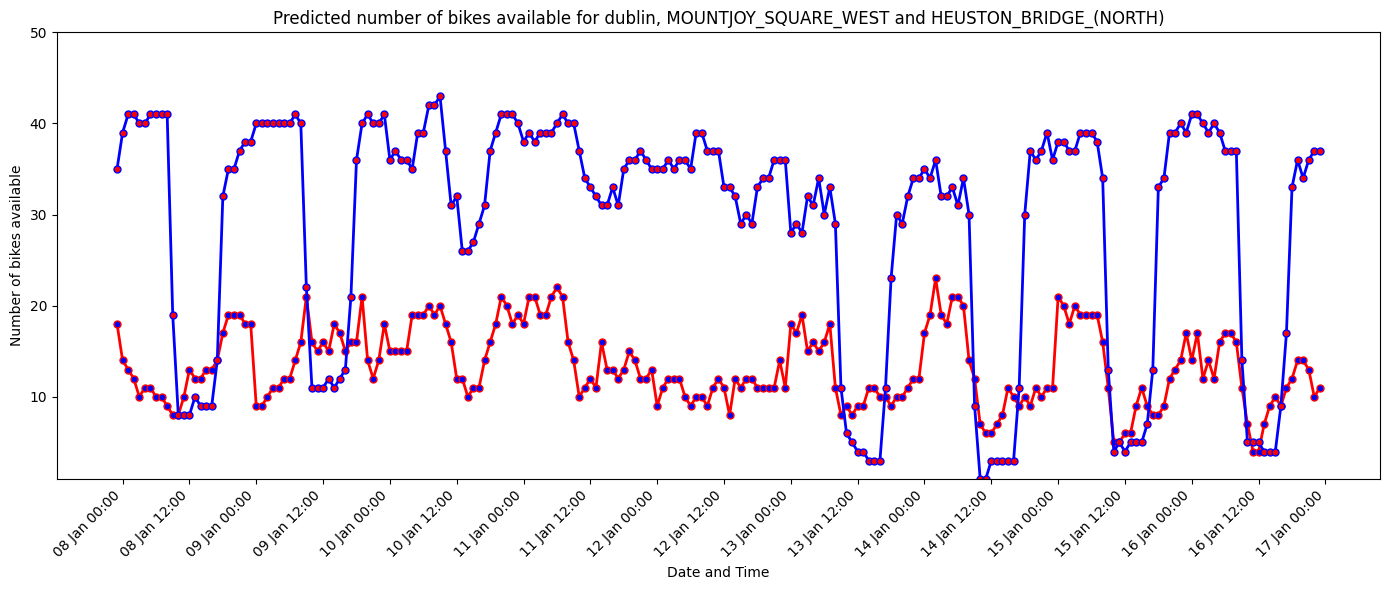

In [13]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION_1, STATION_2, batch_data, file_path)
plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring',
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1207494/fs/1195126/fg/1394733


Uploading Dataframe: 100.00% |██████████| Rows 217/217 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-07 21:27:58,265 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-07 21:28:01,445 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


In [ ]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time >= 24).read()
monitoring_df